### MCMC Example 3

The kitchen sink: extending the parameter space to include the eclipse period.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numba import njit, float64, int32
from numba.experimental import jitclass
from scipy.stats import kde
import pygtc

from typing import List
Vector = List[float]

plt.rcParams['figure.dpi'] = 150

import numpy.random as rng
seed = 9812631
rng.seed(seed)
@njit
def xiN(N):
    return rng.rand(N)
@njit
def xi():
    return rng.rand()
@njit
def xiNormalN(N):
    return rng.randn(N)
@njit
def xiNormal():
    return rng.randn()

@njit
def gam(shape, scale):
    return rng.gamma(shape, scale, size=1)[0]
@njit
def gamN(shape, scale, N):
    return rng.gamma(shape, scale, size=N)

Our model function in this case includes the period of the eclipse as a parameter; we simply fold the data
*modulo* the chosen period, after which the model function is the same as before. 

In [2]:
@njit
def modelFunction(t: np.ndarray, w: np.ndarray) -> np.ndarray :
    M, dm, p, dp, pe = w
    phase = np.mod(t,p)
    return np.where( (phase>pe-dp/2) & (phase<pe+dp/2), M-dm, M)


Folding the data modulo some period and then computing a likelihood function, when done over a range of periods, produces what is known as a *periodogram*. When the model function is sines and cosines, this is similar in some sense to taking the Fourier transform, but without the requirement of equally-spaced data. We will have more to say about periodograms later.

For now, generating the fake data goes much as has before, except we now take a sample of observation times over an interval many time the period in length.

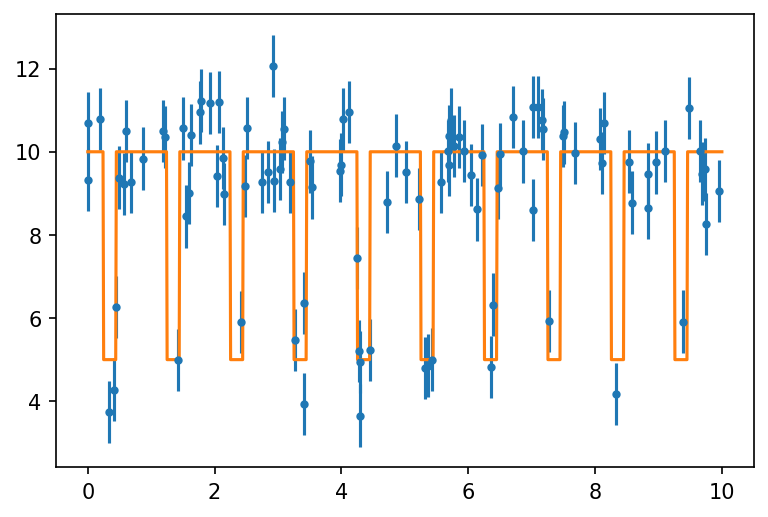

In [3]:
# Parameters for the simulated observations:
M0 = 10
dm0 = 5
p0 = 1
dp0 = 0.2
pe0 = 0.35

# sample size:
N = 100

# sample duration
duration = 10

# variance on each observation:
sig0 = 0.75

# vector of "true" parameters
w0 = np.array([M0, dm0, p0, dp0, pe0])

data = np.zeros((N,3))
data[:,0] = np.sort(xiN(N)*duration)
data[:,1] = modelFunction(data[:,0], w0) + sig0*xiNormalN(N)
data[:,2] = np.ones(N)*sig0

wp = np.zeros_like(w0)
wp[:] = w0
wp[0] = 0
wp[1] = -dm0
foo = modelFunction(data[:,0], wp) + data[:,1]
muM0 = foo.mean()
sigM0 = np.sqrt(foo.var())

truth = np.array([muM0, dm0, p0, dp0, pe0, sigM0])

fig, ax = plt.subplots()
ax.errorbar(data[:,0], data[:,1], fmt='.', yerr=data[:,2])
xx = np.linspace(0,duration,1000)
ax.plot(xx, modelFunction(xx,w0))

Notice how sensitive the model is to having the correct period. Here is the same data, with the period of the model
off by 5%:

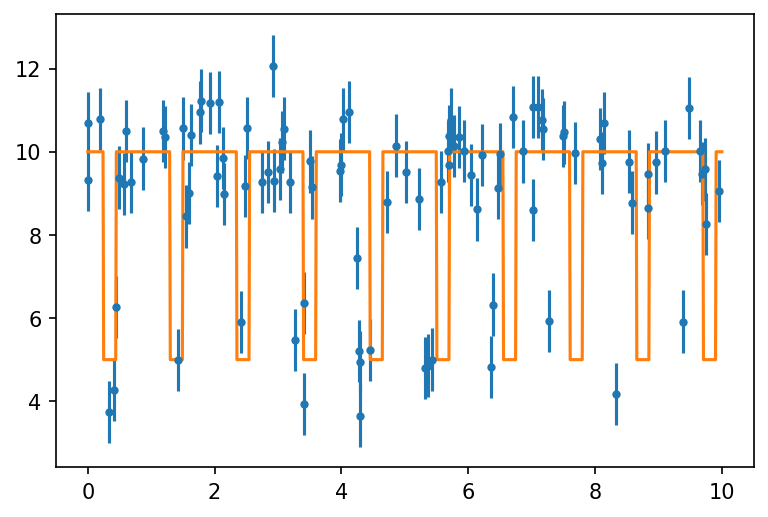

In [4]:
fig, ax = plt.subplots()
ax.errorbar(data[:,0], data[:,1], fmt='.', yerr=data[:,2])
xx = np.linspace(0,duration,1000)
wcopy = np.zeros_like(w0)
wcopy[:] = w0
wcopy[2] = 1.05
ax.plot(xx, modelFunction(xx,wcopy))

That said, there are all sorts of problems with finding the correct period, including *aliasing*. Here is the same plot with the model period half that of the real period; the model fits just as well!

There is a lot more to finding periodicity, especially in unequally-spaced data, than one might at first suspect...

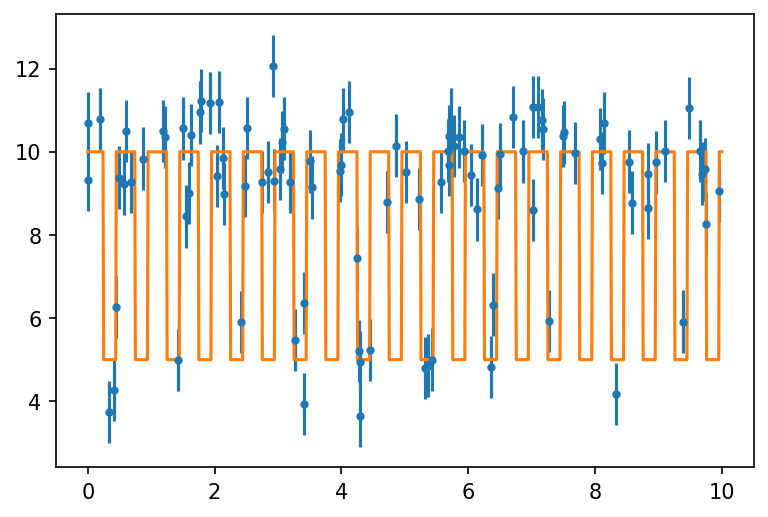

In [5]:
fig, ax = plt.subplots()
ax.errorbar(data[:,0], data[:,1], fmt='.', yerr=data[:,2])
xx = np.linspace(0,duration,1000)
wcopy = np.zeros_like(w0)
wcopy[:] = w0
wcopy[2] = 0.5
ax.plot(xx, modelFunction(xx,wcopy))

Nonetheless, in the spirit of experimentation we will forge ahead!

In [6]:
spec = [
    ('wRange', float64[:,:]),
    ('nParams', int32),
    ('mixParams', float64[:]),
    ('sigParams', float64[:]),
    ('chain', float64[:,:])
]

@jitclass(spec)
class MCMC:
    def __init__(self, wRange: np.ndarray, mixParams: np.ndarray, sigParams: np.ndarray):
        # Ranges in parameter values:
        self.wRange = wRange
        self.nParams = wRange.shape[0]
        self.mixParams = mixParams
        self.sigParams = sigParams
        
    def logPrior(self, w: np.ndarray) -> float :
    
        for i in range(w.shape[0]):
            if (w[i] < self.wRange[i,0]) or (w[i] > self.wRange[i,1]):
                return -np.Inf
        return 0.0
    
    def samplePrior(self) -> np.ndarray :
        w = np.zeros(self.nParams, dtype=np.float64)
        for i in range(self.nParams):
            w[i] = (wRange[i,1]-wRange[i,0])*xi() + wRange[i,0]

        return w

    def propose(self, w: np.ndarray, i) -> np.ndarray:
        nParam = w.shape[0]
        wNew = np.zeros_like(w, dtype=np.float64)
        wNew[:] = w

        # Which one should we change?
        #i = int(xi()*nParam)
        eps = self.sampleMixture(self.mixParams[0], self.mixParams[1])
        wNew[i] += (wRange[i,1]-wRange[i,0])*eps

        return wNew

    def logLikelihood(self, data: np.ndarray, w: np.ndarray, sigma2: float) -> List[np.float64]:
        """
        Log of the likelihood given the parameters
        data[:,0] = the observed phase
        data[:,1] = the observed magnitude
        data[:,2] = the reported error in the individual observations
        sigma2: the variance on each of the data points
        """
        N = data.shape[0]
        
        ss2 = np.sum( (data[:,1] - modelFunction(data[:,0],w))**2 )
        
        logl = -0.5*N*np.log(2*np.pi) - 0.5*N*np.log(sigma2) - 0.5*ss2 / sigma2

        return ss2, logl

    def run(self, Nsteps, data):

        # start off at some random w drawn from our prior distribution
        w = self.samplePrior()
        # and sigma2 from our prior
        sigma2 = 1.0/rng.gamma(0.5*self.sigParams[0], 
                               1.0/(0.5*self.sigParams[0]*self.sigParams[1]),size=1)[0]

        # Compute log prior and log likelihood
        logp = self.logPrior(w)
        sumOfSquares, logl = self.logLikelihood(data, w, sigma2)

        N = data.shape[0]
        nParam = w.shape[0] # the value of w plus its sigma and log likelihood
        self.chain = np.zeros((Nsteps, nParam + 2), dtype=np.float64)

        # count the number of successful proposals
        ngood = 0

        cnt = 0
        for i in range(Nsteps):
            for j in range(self.nParams):
                wNew = self.propose(w, j)
                logpNew = self.logPrior(wNew)

                # Only evaluate the likelihood if prior prob isn't zero
                loglNew = -np.Inf
                if logpNew != -np.Inf:
                    sumOfSquares, loglNew = self.logLikelihood(data, wNew, sigma2)
           
                # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w)p(w) )
                logRatio = (logpNew + loglNew) - (logp + logl)
                logRatio = min(0.0, logRatio)

                # Acceptance/rejection
                if xi() <= np.exp(logRatio):
                    w = wNew
                    logp = logpNew
                    logl = loglNew
                    ngood += 1
            
            # Gibbs sampler for sigma^2: move is always accepted
            shape = 0.5*(self.sigParams[0] + N)
            scale = 0.5*(self.sigParams[0]*self.sigParams[1] + sumOfSquares)
            sigma2 = 1.0/gam(shape, 1.0/scale)
            
            self.chain[i, :-2] = w
            self.chain[i, -2] = np.sqrt(sigma2)
            self.chain[i, -1] = logl
                
        return ngood/(Nsteps*self.nParams)
    
    def sampleMixture(self, a, b):
        return 10.0**(a - b*np.abs(xiNormal()/np.sqrt(-np.log(xi()))))*xiNormal()

In order to avoid some aliasing problems, we will take our prior on the the period to be uniform above the alias at 1/2/

In [7]:
# Prior on parameters is uniform within these ranges
wRange = np.array([[-100,100],[0, 10], [0.6,5], [0, 1], [0, 1]], dtype=np.float64)

# Width of distribution from which to sample proposed moves
mixParams = np.array([1.5, 6], dtype=np.float64)

# parameters for the posterior probability of the variance in the data
sigParams = np.array([3, 1.0])

# Run the chain
doit = MCMC(wRange, mixParams, sigParams)

goodFrac = doit.run(10**6, data)
print(f"\n\nAcceptance ratio: {goodFrac}")



Acceptance ratio: 0.4160764


In [8]:
def plotChain(chain, labs):
    nParams = chain.shape[1]-2
    fig, ax = plt.subplots(nParams+2, 1, sharex=True)
    for i in range(nParams):
        ax[i].plot(chain[:,i])
        ax[i].set_ylabel(labs[i])
    ax[-2].plot(chain[:,-2])
    ax[-2].set_ylabel('$\sigma$')
    ax[-1].plot(chain[:,-1])
    ax[-1].set_ylabel('$\log\mathcal{L}$')

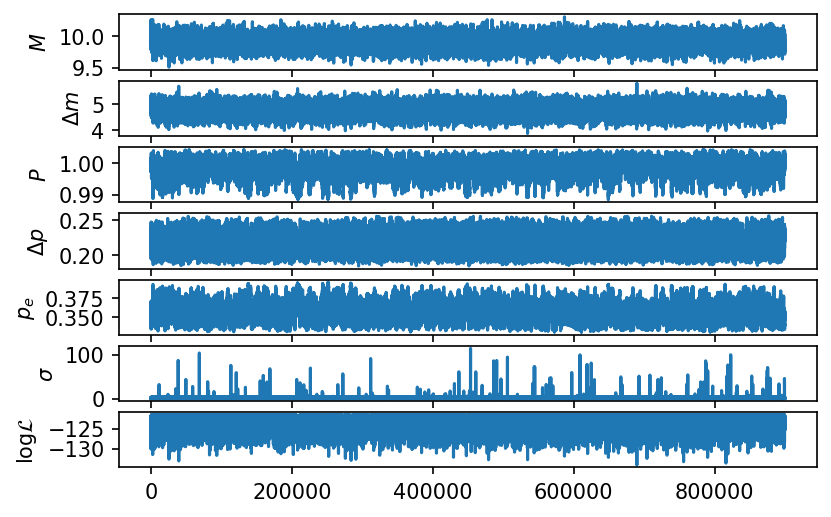

In [9]:
labs = ['$M$','$\Delta m$', '$P$', '$\Delta p$', '$p_e$', '$\sigma$']
burn = 10**5
plotChain(doit.chain[burn:,:], labs)

In [10]:
# don't let several big values of sigma distort the plots...
foo = doit.chain[burn:,-2]
foo = np.where(foo>2, 2, foo)
doit.chain[burn:,-2] = foo

In [11]:
def plotSlice(samples, w0, truth, a, b, labs):
    M = samples[:,a]
    dm = samples[:,b]

    fig, ax = plt.subplots(2, 2)
    hts, edges, pat = ax[0,0].hist(M,bins=30, density=True, histtype='step')
    ax[0,0].set_xlim(M.min(), M.max())
    ax[0,0].plot([truth[a],truth[a]], [hts.min(),hts.max()], 'g')
    if a < w0.shape[0]:
        ax[0,0].plot([w0[a],w0[a]], [hts.min(),hts.max()],'r')
    
    ax[0,1].remove()

    ax[1,0].scatter(M, dm, marker='.', s=1)
    ax[1,0].set_ylim(dm.min(), dm.max())
    ax[1,0].set_xlim(M.min(), M.max())
    ax[1,0].set_ylim(dm.min(), dm.max())
    ax[1,0].plot(truth[a], truth[b],'w+')
    if b < w0.shape[0]: ax[1,0].plot(w0[a], w0[b],'r+')
    ax[1,0].set_xlabel(labs[a])
    ax[1,0].set_ylabel(labs[b])

    hts, edges, pat = ax[1,1].hist(dm, bins=30, density=True, orientation='horizontal', histtype='step')
    ax[1,1].set_ylim(dm.min(), dm.max())
    ax[1,1].plot([hts.min(),hts.max()], [truth[b],truth[b]],'g')
    if b < w0.shape[0]: ax[1,1].plot([hts.min(),hts.max()], [w0[b],w0[b]],'r')

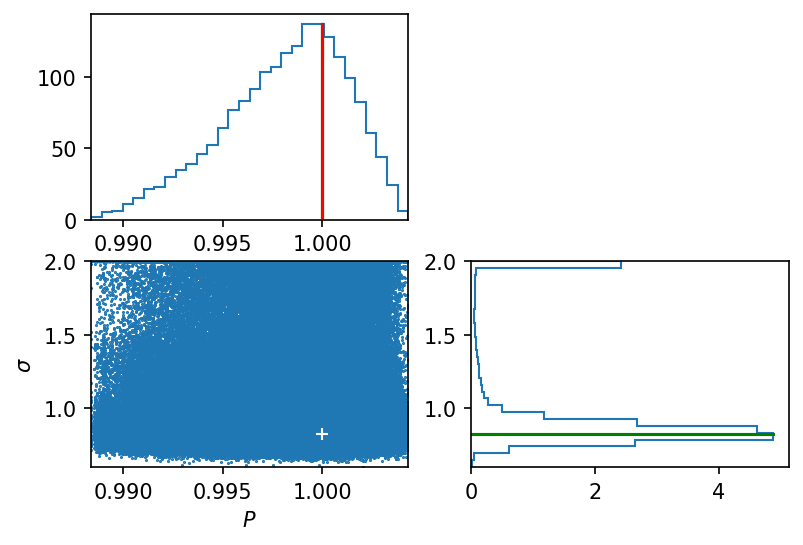

In [12]:
plotSlice(doit.chain[burn:,:], w0, truth, 2,5, labs)

Text(0, 0.5, '$P(\\sigma)$')

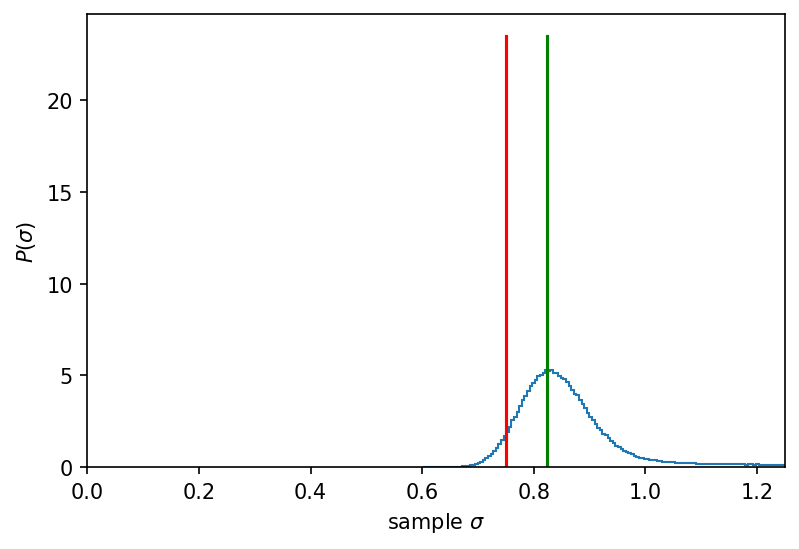

In [13]:
fig, ax = plt.subplots()
hts, bins, ignore = ax.hist(doit.chain[burn:,-2], bins=300, density=True, histtype='step');
ax.plot([truth[5],truth[5]], [hts.min(), hts.max()],'g')
ax.plot([sig0,sig0], [hts.min(), hts.max()],'r')
ax.set_xlim(0,1.25)
ax.set_xlabel('sample $\sigma$')
ax.set_ylabel('$P(\sigma)$')

Notice that there are significant correlations between $P$, $p_e$, and $\Delta p$. Clearly our assumption of uncorrelated priors is not very good, and we should be taking covariance into account. Nonetheless, the MCMC distributions seem to peak near the true values; the error bars will be rather further off due to these correlations.

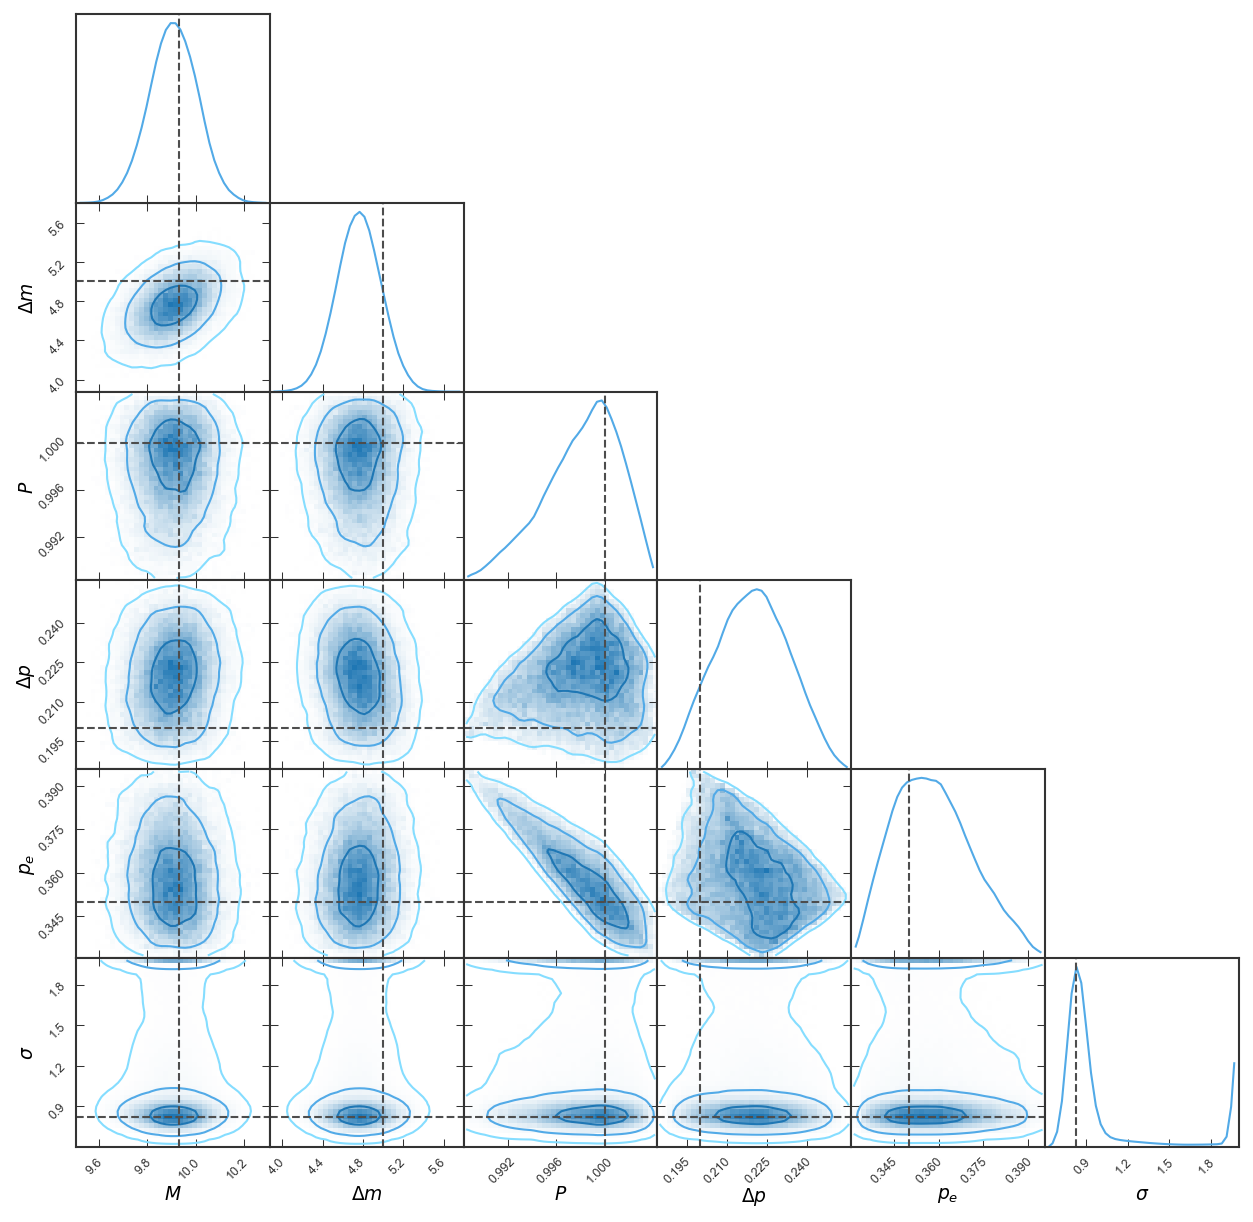

In [14]:
import pygtc
pygtc.plotGTC(chains=[doit.chain[burn:,:-1]],
              paramNames=labs,
              truths=truth,
              nBins=40,
              smoothingKernel=1,
              nContourLevels=3,
              filledPlots=False,
              plotDensity=True,
              sigmaContourLevels=True,
              figureSize=10);

In [15]:
def autocorrelate(x,lags):
    n=len(x)
    # pad 0s to 2n-1
    size=2*n-1
    
    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp, size)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]


def auto(chain, nlag, labs):
    nParam = chain.shape[1]-1
    lags = np.arange(nlag)
    fig, ax = plt.subplots()
    for i in range(nParam):
        result = autocorrelate(chain[:,i],lags)
        ax.plot(result, label=labs[i])
    ax.legend()
    ax.set_xlabel('lag k [steps]')
    ax.set_ylabel('P(k)')
    plt.tight_layout();

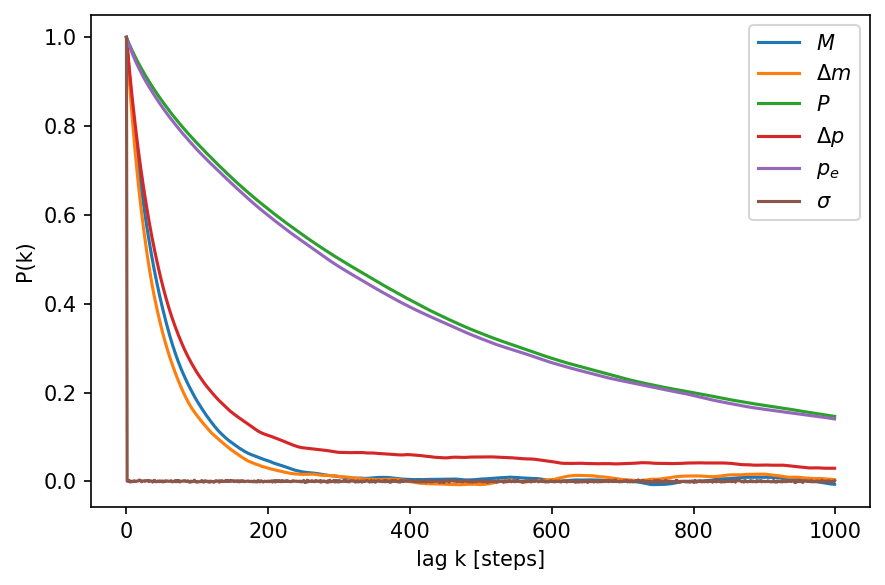

In [16]:
lags = range(0,800)
end = -1
auto(doit.chain[burn:,:], 1000, labs)